# scRNAseq downstream analysis
Based on Jupyter Notebook created by Lauren Sanders

### Updates:

1. Wrote script to zip all downloaded samples and give possibility to open as adata
2. Wrote script to modify marker table and adapted to be read by ScoreCT
3. Prepared the function that will process and plot all data that are needed to visualization - the function is also written to be easily incorporated with Django (system that is used on Viz Portal)
4. Finished cell type annotation with scoreCT - it works properly, when good markers are provided.
5. Found tools for DE analysis: I will test them in next update; Python: diffxpy, PyDESeq2, R: DESeq2 - I will compare them together
6. added optional function to run mt filtering step - works on booleans
7. it is possible to interactively compare multiple samples/tissues/genes at the same time - I have to face with scalability challenges and probably I need to move all plots to separate function / script

### Script: Zip all files for scanpy:

In [4]:
#load libraries:
import os
import gzip
import shutil

In [ ]:
# Set the working folder:
root_folder = './test/'

In [13]:
# Define the file extensions we are looking for
extensions = ('.tsv', '.mtx')

# Function to find and zip files
def zipper(root_folder):
    # Walk through the directory, including subdirectories
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            # Check if the file is in a 'filtered' subdirectory
            if 'filtered' in root:
                # Check for the desired file extensions
                if file.endswith(extensions):
                    file_path = os.path.join(root, file)
                    output_path = file_path + '.gz'  # Create the .gz filename
                    
                    # Zip the file
                    with open(file_path, 'rb') as f_in:
                        with gzip.open(output_path, 'wb') as f_out:
                            shutil.copyfileobj(f_in, f_out)
                    
                    print(f"Successfully zipped: {file_path} to {output_path}")
                else:
                    print(f"Skipping non-target file: {file}")

zipper(root_folder)


Successfully zipped: ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene\filtered\barcodes.tsv to ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene\filtered\barcodes.tsv.gz
Skipping non-target file: barcodes.tsv.gz
Successfully zipped: ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene\filtered\features.tsv to ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene\filtered\features.tsv.gz
Skipping non-target file: features.tsv.gz
Successfully zipped: ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene\filtered\matrix.mtx to ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene\filtered\matrix.mtx.gz
Skipping non-target file: matrix.mtx.gz
Successfully zipped: ./test/RRRM2_Femur_BM_FLT_LAR_YNG_FY11_Gene\filtered\barcodes.tsv to ./test/RRRM2_Femur_BM_FLT_LAR_YNG_FY11_Gene\filtered\barcodes.tsv.gz
Skipping non-target file: barcodes.tsv.gz
Successfully zipped: ./test/RRRM2_Femur_BM_FLT_LAR_YNG_FY11_Gene\filtered\features.tsv to ./test/RRRM2_Femur_BM_FLT_LAR_YNG_FY11_Gene\filtered\features.tsv.gz
Skipping non-target file: features.tsv.gz
Success

### Script: prepare marker table for scoreCT:

In [ ]:
#Load libraries:
import pandas as pd

#Load inputs:
df_input='GL-DPPD-7111_Mmus_BoneMarrow_CellType_GeneMarkers.csv'
df_output='GL-DPPD-7111_Mmus_BoneMarrow_CellType_GeneMarkers_filtered.csv'
column_name='cellName'
column_gene='geneSymbol'

#load_data:
df = pd.read_csv(df_input)
df = pd.DataFrame(df)
#Select only cellName and geneSymbol:
df_selected = df[[column_name, column_gene]]
#Create new column for each representing gene:
df_split = df_selected[column_gene].str.split(',', expand=True)
# Concatenate the "one" column with the newly split columns
df_result = pd.concat([df[[column_name]], df[column_gene].str.split(',', expand=True)], axis=1).to_numpy()
#save results:
pd.DataFrame(df_result).to_csv(df_output, header=False, index=False)

## Script: scRNAseq analysis:
load all libraries necessary to run all scripts.

In [37]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

import os
import sys
import scanpy as sc
import scorect as ct
# Ignore warnings in this tutorial
import warnings
warnings.filterwarnings('ignore')

scanpy==1.10.4 anndata==0.11.1 umap==0.5.7 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.8 pynndescent==0.5.13


In [64]:
#Select inputs:
OSD = "OSD-402"
exp_name = "RRRM2"
tissue = "Femur"
exp_place = "FLT"
age = "OLD"
sample = "FO1"

input_path = "./" + OSD + "/experiments_gene/" + exp_name + "_" + tissue + "_BM_" + exp_place + "_LAR_" + age + "_" + sample + "_Gene/filtered/"
input_marker_path = 'GL-DPPD-7111_Mmus_BoneMarrow_CellType_GeneMarkers_filtered.csv'
#select parameters:
organism_filtering = ["mouse"]
if organism_filtering == "mouse":
    par_min_genes = 200
    par_min_cells = 3
#PCA variance plot:
pca_pcs =50

Function, that takes as input multiple files and gives possibility to manipulate min genes/cells cutoff.

In [73]:
def sc_process(input_path, organism_filtering, mt_analysis):
    # Read the 10x data
    adata = sc.read_10x_mtx(input_path, var_names='gene_symbols', cache=True)

    # Basic filtering:
    sc.pp.filter_cells(adata, min_genes=par_min_genes)
    sc.pp.filter_genes(adata, min_cells=par_min_cells)

    if mt_analysis:
        mitochondrial_prefixes = ["MT-", "mt-", "M-", "m-", "mito-", "MITO-"]

        # Find which prefix is used in your data
        for prefix in mitochondrial_prefixes:
            mt_genes = [gene for gene in adata.var_names if gene.startswith(prefix)]
            if mt_genes:
                print(f'Prefix "{prefix}" found with {len(mt_genes)} mitochondrial genes:')
                print(mt_genes[:10])  # Print the first 10 mitochondrial genes found
                break
        else:
            print("No common mitochondrial gene prefix found in the first 50 gene names.")

        # Annotate the group of mitochondrial genes as "mt"
        adata.var["mt"] = adata.var_names.str.startswith("mt-")

        # Calculate QC metrics
        sc.pp.calculate_qc_metrics(
            adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

        # Plot QC metrics: violin plot
        sc.pl.violin(
            adata,
            ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
            jitter=0.4,
            multi_panel=True)

        # Scatter: percent mitochondrial counts, number of genes vs total counts
        sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", title="Percent of mitochondrial counts")
        sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", title="Number of genes vs total counts")

        # Filter out mitochondrial genes:
        adata = adata[adata.obs.n_genes_by_counts < 2500, :]
        adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

    # Calculate total counts (needed for regression)
    sc.pp.calculate_qc_metrics(adata, inplace=True)

    # Normalization by library size:
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Save for DE analysis - raw:
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata.raw = adata

    # Filter highly variable genes:
    adata = adata[:, adata.var.highly_variable]
    
    # Regress out the variables conditionally
    if "pct_counts_mt" in adata.obs:
        sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
    else:
        sc.pp.regress_out(adata, ["total_counts"])

    # Scale the data:
    sc.pp.scale(adata, max_value=10)

    # Calculate PCA:
    sc.tl.pca(adata, svd_solver="arpack")

    # PCA variance plot:
    sc.pl.pca_variance_ratio(adata, log=True, n_pcs=pca_pcs)

    # Compute clusters:
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata)

    # Plot top 20 genes:
    sc.pl.highest_expr_genes(adata, n_top=20)

    # Cluster Leiden:
    sc.tl.leiden(adata)

    # Differential expression analysis between clusters:
    sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")

    # Use scoreCT:
    ct.scorect(adata,
               marker_path=input_marker_path,
               K_top=300,
               m_bins=5,
               null_model='multinomial',
               cluster_key='leiden')

    # Plot UMAP:
    sc.pl.umap(adata, color=['scoreCT'], title=["UMAP of file:"], wspace=0.33)
    
    return adata


... reading from cache file cache\OSD-402-experiments_gene-RRRM2_Femur_BM_FLT_LAR_OLD_FO1_Gene-filtered-matrix.h5ad
filtered out 189 cells that have less than 200 genes expressed
filtered out 37945 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:21)
computing PCA
    with n_comps=50
    finished (0:00:02)


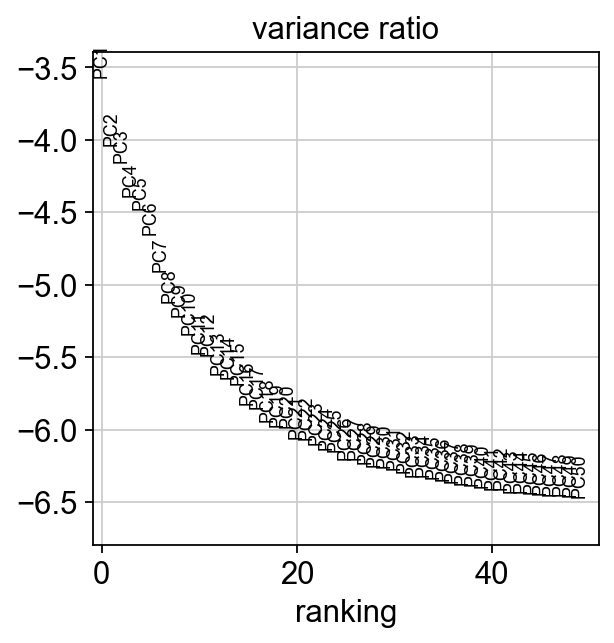

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:04)
normalizing counts per cell
    finished (0:00:00)


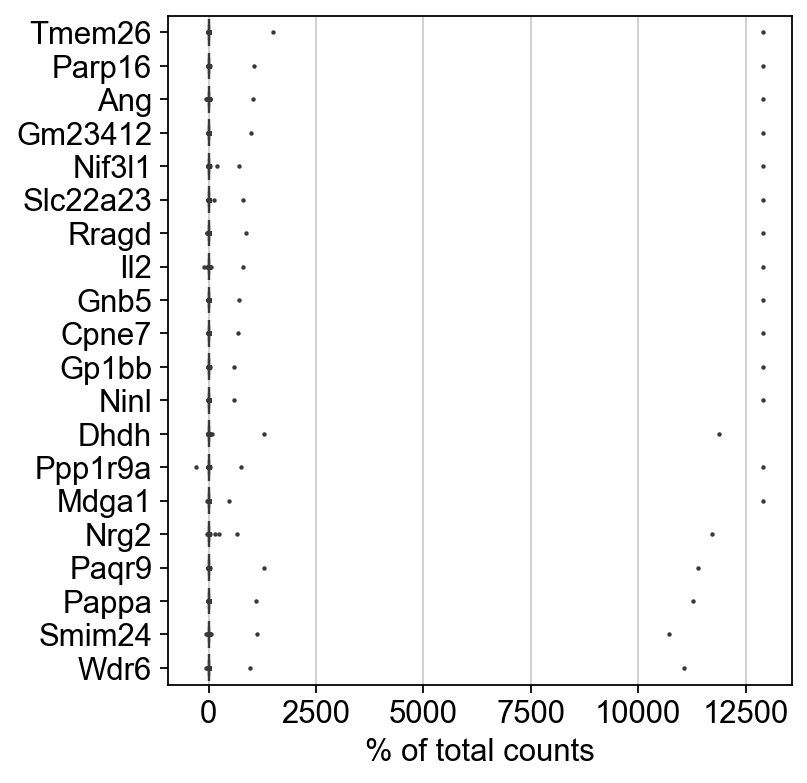

running Leiden clustering
    finished: found 23 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)
Reading markers...
Wrangling: Number of markers used in ranked_gene_groups:  18803
Wrangling: Groups used for ranking: leiden
Scoring cell types in reference...
Assigning cell types in adata.obs['scoreCT']...


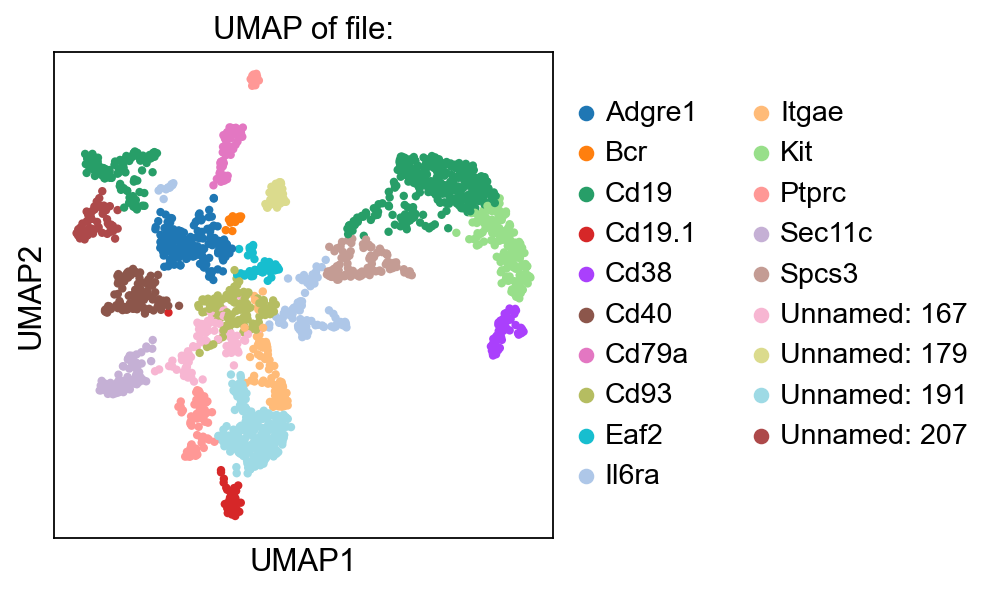

AnnData object with n_obs × n_vars = 2108 × 4507
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'scoreCT'
    var: 'gene_ids', 'feature_types', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'rank_genes_groups', '_scorect', 'scoreCT_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [74]:
sc_process(input_path, "mouse", mt_analysis=False)

### Script: retrieve all file paths:

In [53]:
base_path = './test'
out = []
# find all subdirectories:
for root, dirs, files in os.walk(base_path):
    # it was a problem with catching invisible folders, fixed it:
    dirs[:] = [d for d in dirs if not d.startswith('.')]
    # Check if the current directory matches the filtered path
    if 'filtered' in root.split(os.sep):
        out.append(root)

out

['./test\\RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene\\filtered',
 './test\\RRRM2_Femur_BM_FLT_LAR_YNG_FY11_Gene\\filtered']

... reading from cache file cache\test-RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene-filtered-matrix.h5ad
filtered out 143 cells that have less than 200 genes expressed
filtered out 37585 genes that are detected in less than 3 cells
Prefix "mt-" found with 36 mitochondrial genes:
['mt-Tf', 'mt-Rnr1', 'mt-Tv', 'mt-Rnr2', 'mt-Tl1', 'mt-Nd1', 'mt-Ti', 'mt-Tq', 'mt-Tm', 'mt-Nd2']


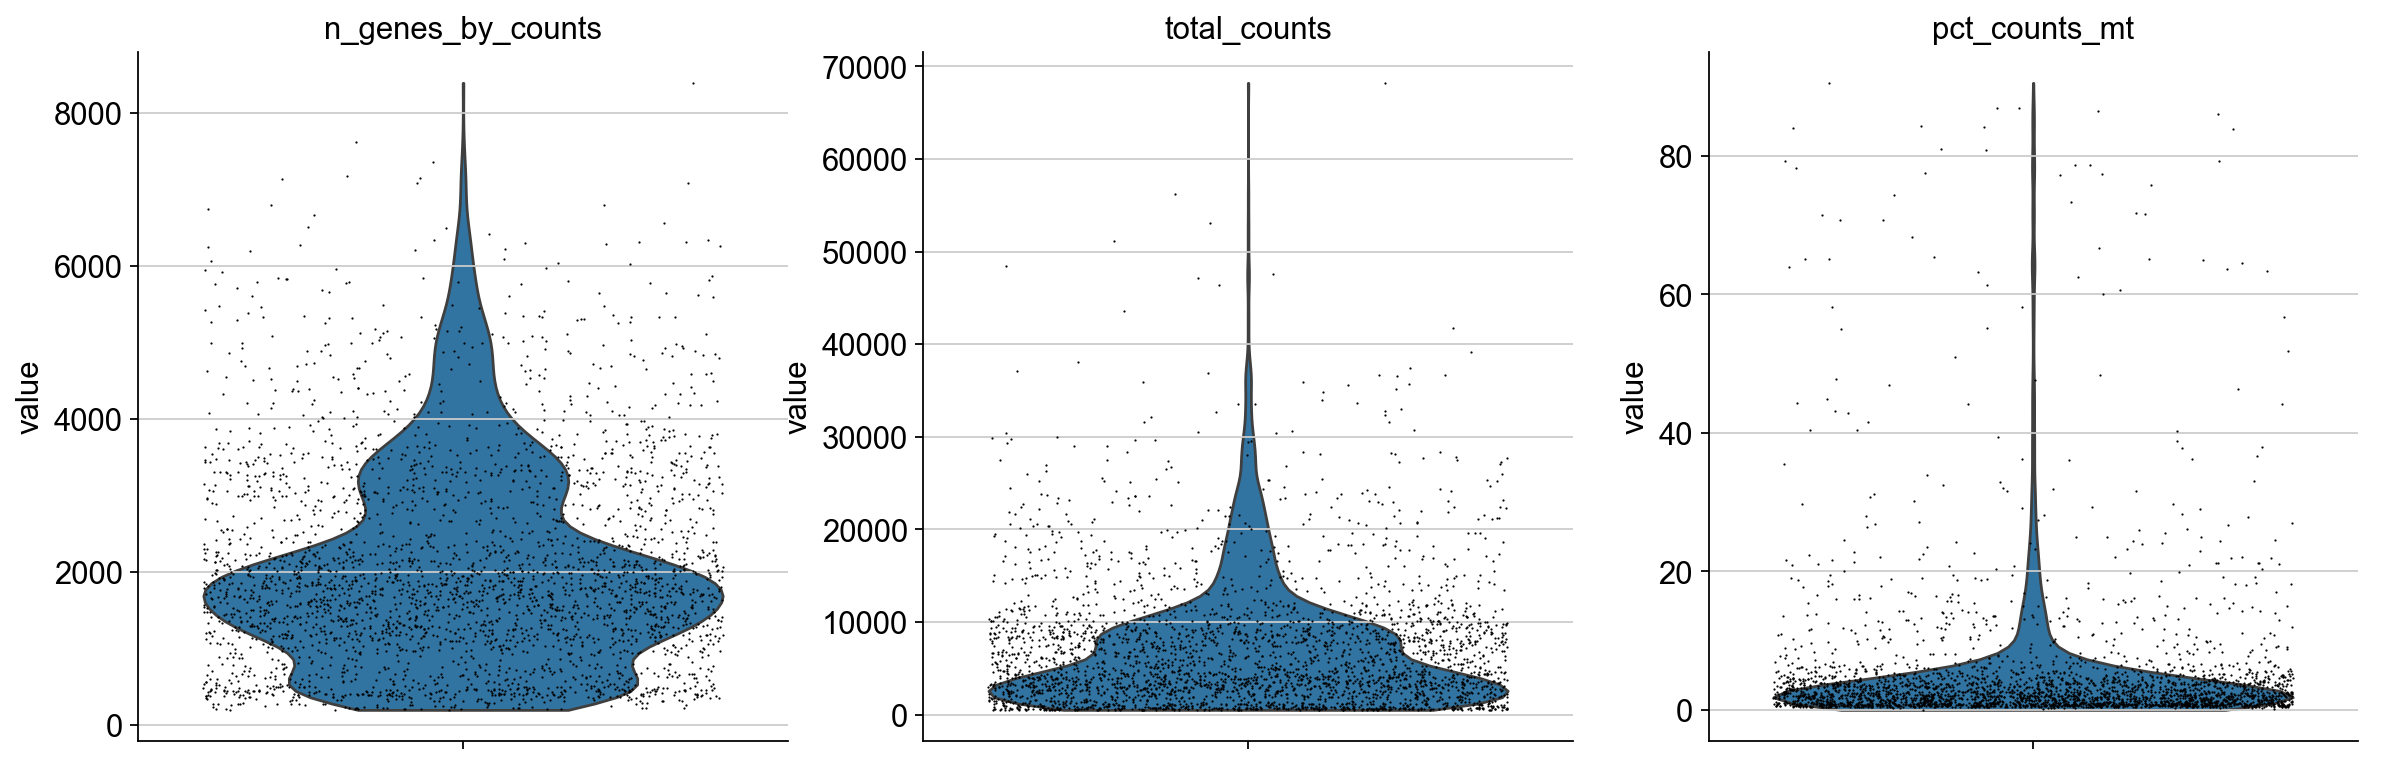

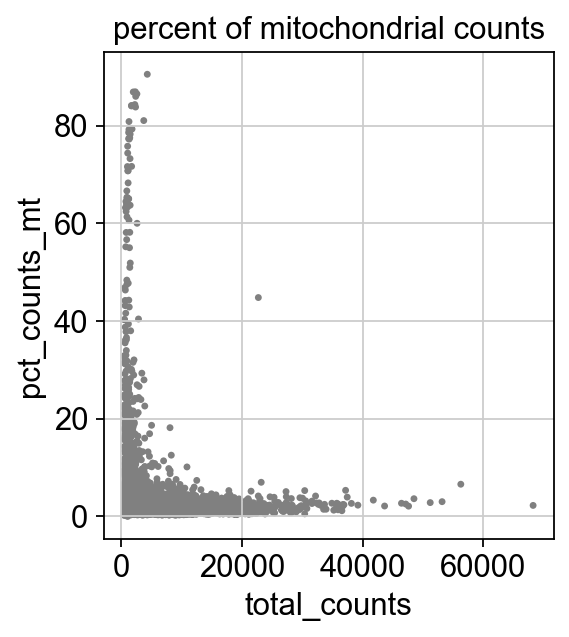

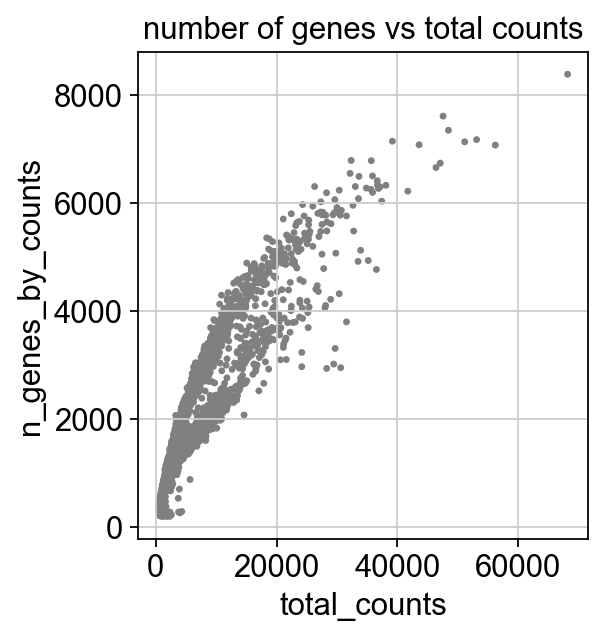

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:19)
computing PCA
    with n_comps=50
    finished (0:00:02)


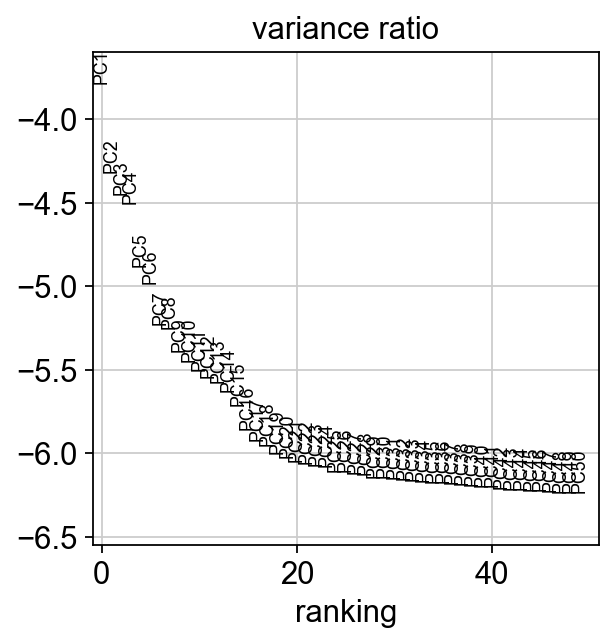

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:03)
normalizing counts per cell
    finished (0:00:00)


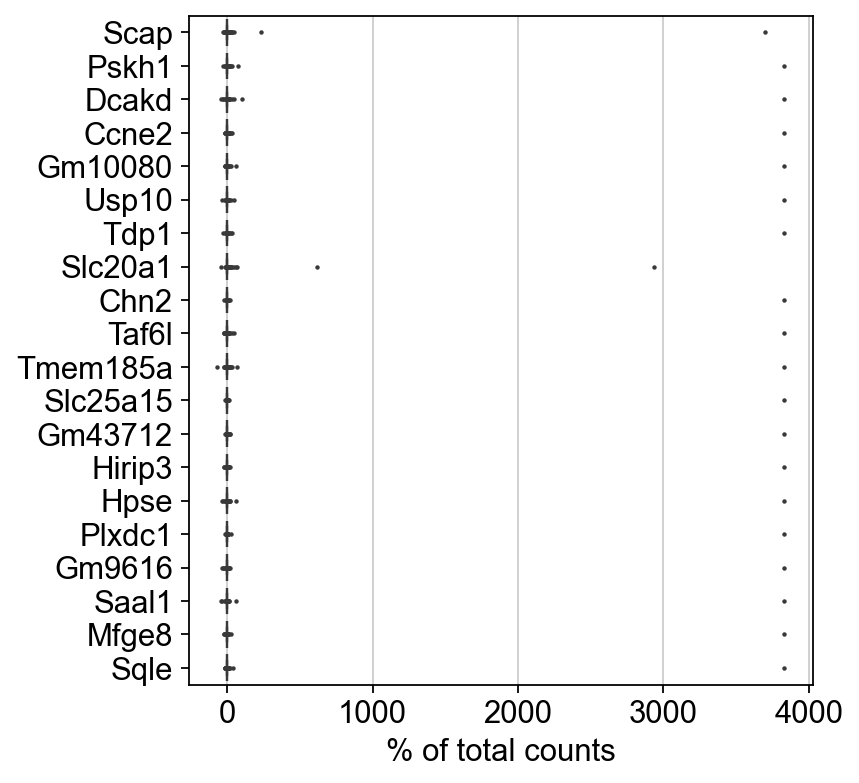

running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)
Reading markers...
Wrangling: Number of markers used in ranked_gene_groups:  19163
Wrangling: Groups used for ranking: leiden
Scoring cell types in reference...
Assigning cell types in adata.obs['scoreCT']...


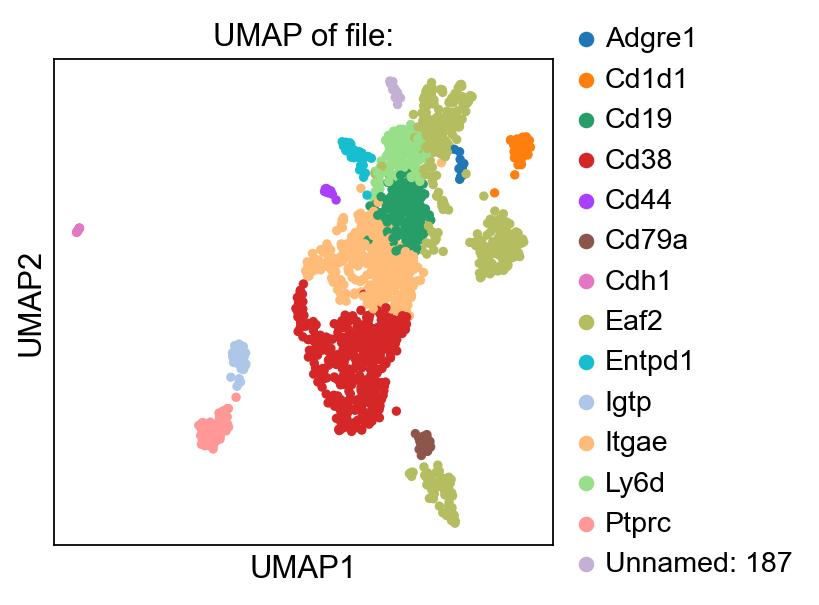

... reading from cache file cache\test-RRRM2_Femur_BM_FLT_LAR_YNG_FY11_Gene-filtered-matrix.h5ad
filtered out 61 cells that have less than 200 genes expressed
filtered out 35432 genes that are detected in less than 3 cells
Prefix "mt-" found with 36 mitochondrial genes:
['mt-Tf', 'mt-Rnr1', 'mt-Tv', 'mt-Rnr2', 'mt-Tl1', 'mt-Nd1', 'mt-Ti', 'mt-Tq', 'mt-Tm', 'mt-Nd2']


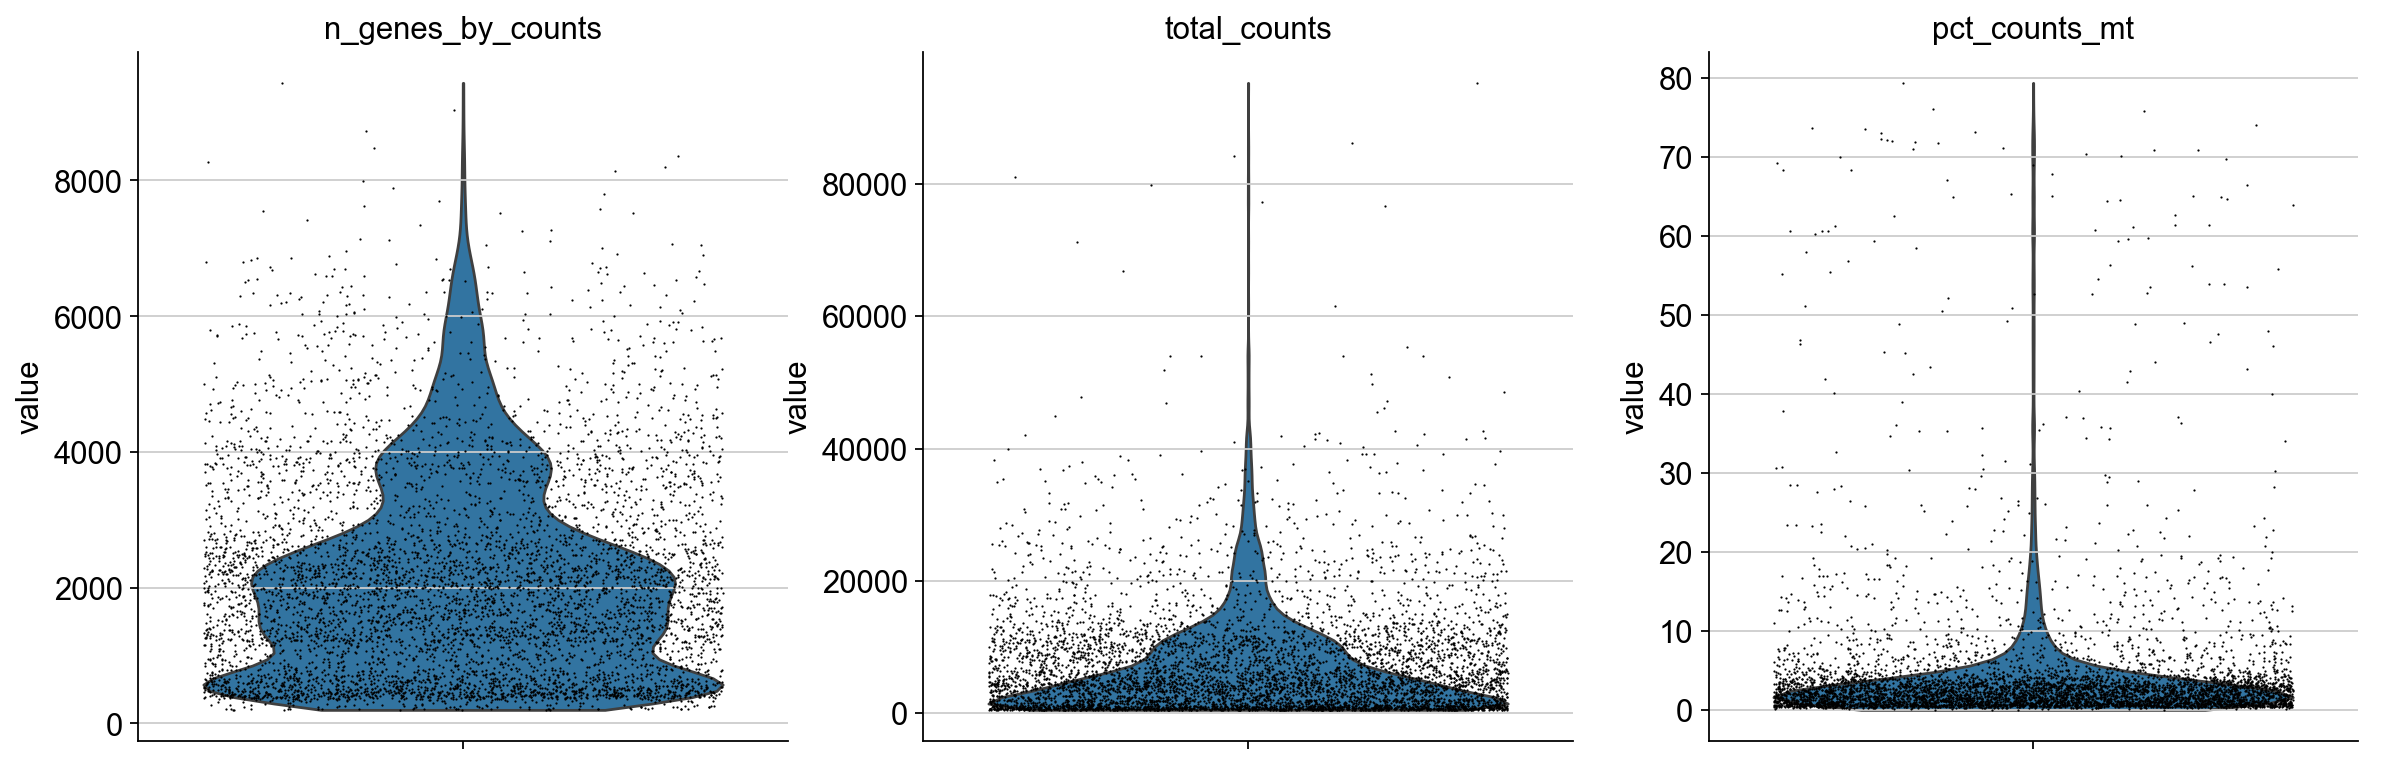

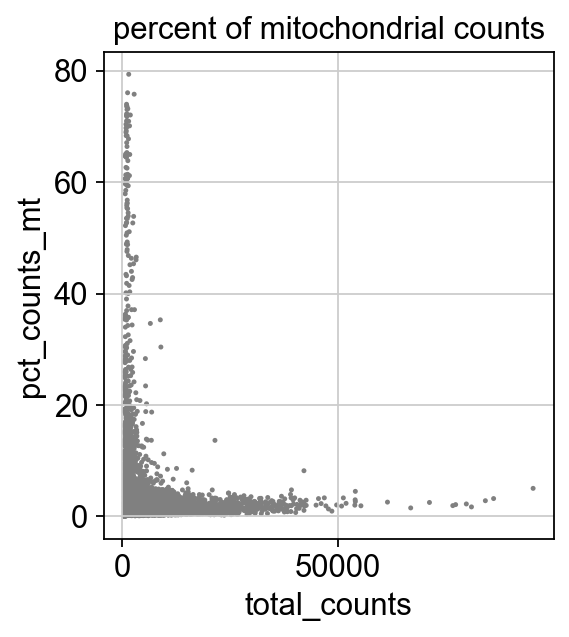

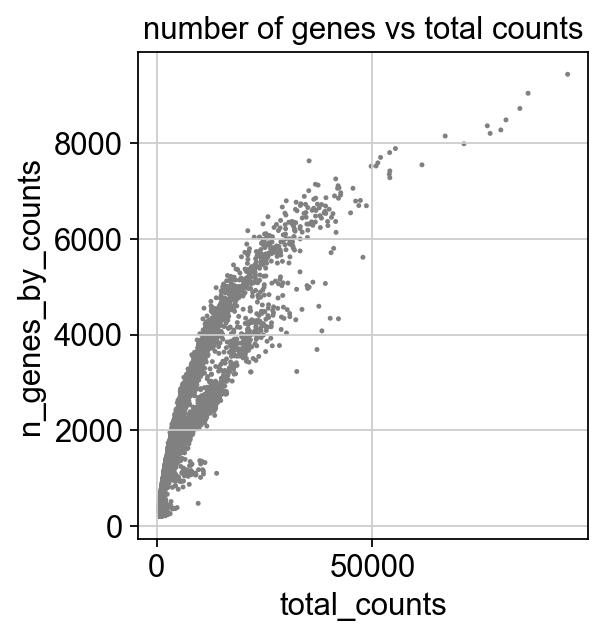

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:33)
computing PCA
    with n_comps=50
    finished (0:00:06)


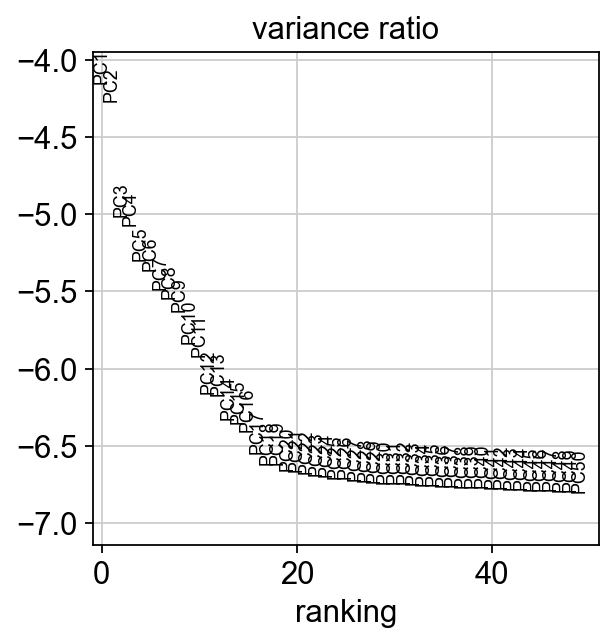

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:06)
normalizing counts per cell
    finished (0:00:00)


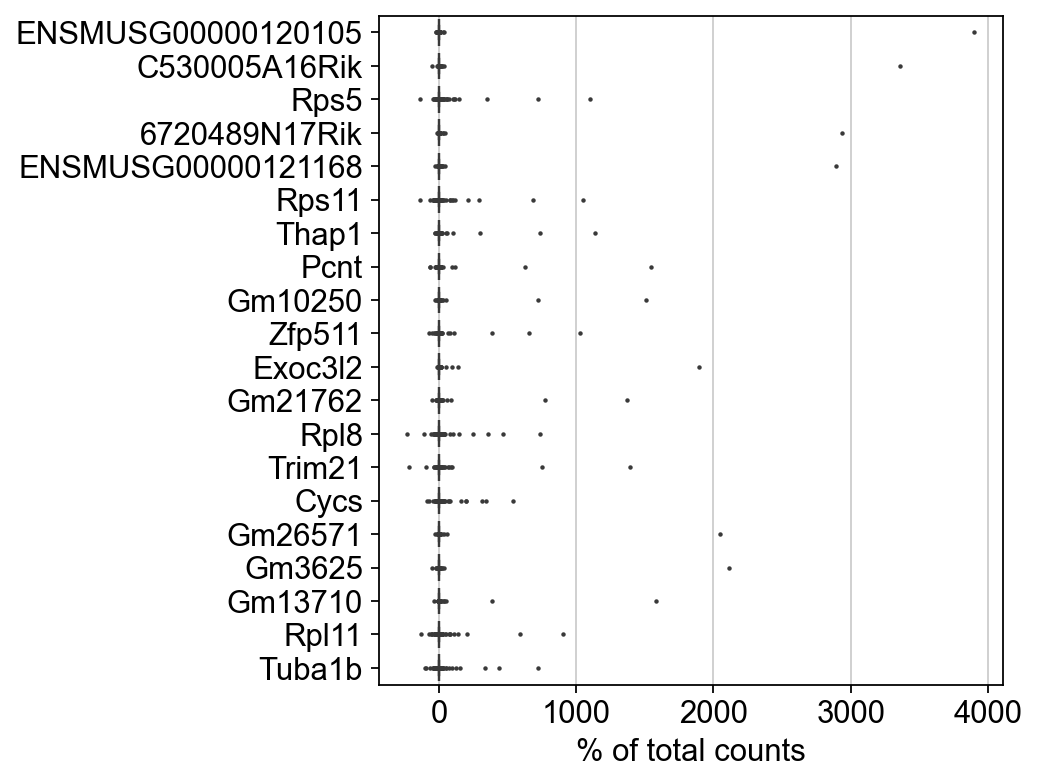

running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:19)
Reading markers...
Wrangling: Number of markers used in ranked_gene_groups:  21316
Wrangling: Groups used for ranking: leiden
Scoring cell types in reference...
Assigning cell types in adata.obs['scoreCT']...


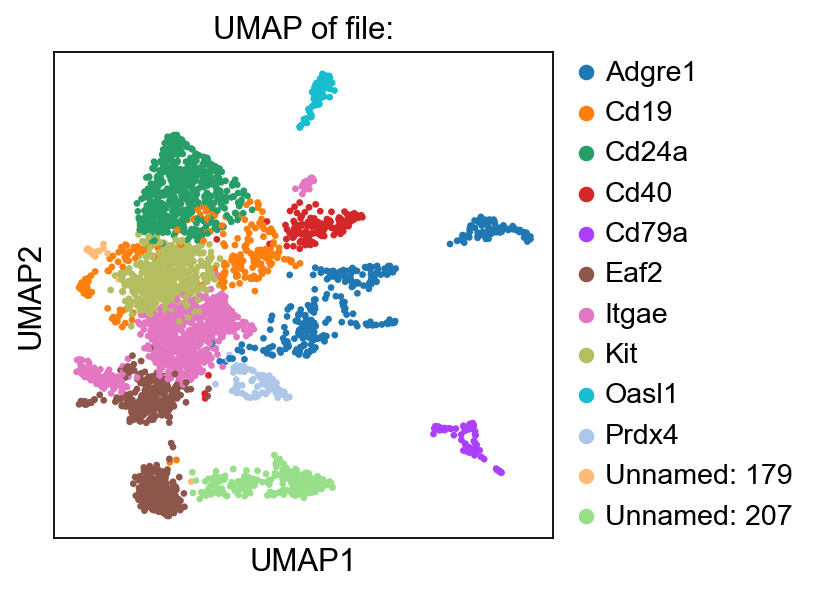

TypeError: argument should be a str or an os.PathLike object where __fspath__ returns a str, not 'AnnData'

In [59]:
scRNAseq_output = []
for input_path in out:
    out.append(sc_process(input_path, "mouse" ))